In [91]:
import os
import cv2
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import RobustScaler, StandardScaler

In [92]:
img_path = "data/Analytical_Cubism/albert-gleizes_acrobats-1916.jpg"

In [93]:
def safe_load_image(filepath):
    """
    Safely load images with error handling and format conversion
    """
    try:
        # Try PIL first (better format support)
        img = Image.open(filepath)

        img = np.array(img)
        img = img.reshape((-1, 3))  # flattens the image
        return np.array(img)

    except Exception as e:
        try:
            # Fallback to OpenCV
            img = cv2.imread(filepath)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                return img
        except:
            pass

        print(f"Failed to load {filepath}: {e}")
        return None

In [94]:
raw_img = safe_load_image(img_path)

In [95]:
raw_img

array([[126, 129, 102],
       [127, 125, 100],
       [137, 129, 110],
       ...,
       [ 99, 101,  96],
       [108, 111, 104],
       [110, 113, 106]], dtype=uint8)

In [96]:
def group_with_kmeans(img,
                      n_clusters=8,
                      random_state=42,
                      normalize=True):
    grouping_result = {}

    # Normalize if requested
    processed_img = img.copy()
    if normalize and img.max() > 1:
        processed_img = img / 255.0

    # Fit K-Means
    kmeans = KMeans(n_clusters=n_clusters,
                    random_state=random_state,
                    n_init=10)
    labels = kmeans.fit_predict(processed_img)

    # Get centroids
    centroids = kmeans.cluster_centers_

    # Convert back to 0-255 range if normalized
    if normalize and img.max() > 1:
        centroids = centroids * 255.0

    # Count img per cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_counts = dict(zip(unique_labels, counts))

    grouping_result = {
        'labels': labels,
        'centroids': centroids,
        'kmeans_model': kmeans,
        'cluster_counts': cluster_counts,
        'n_clusters': n_clusters
    }

    return grouping_result

In [ ]:
def group_with_kmedoids(img,
                        n_clusters=8,
                        random_state=42,
                        normalize=True,
                        method='alternate',
                        max_iter=300):
    grouping_result = {}

    # Normalize if requested
    processed_img = img.copy()
    if normalize and img.max() > 1:
        processed_img = img / 255.0

    # Fit K-Medoids
    kmedoids = KMedoids(n_clusters=n_clusters,
                       random_state=random_state,
                       method=method,
                       max_iter=max_iter)
    labels = kmedoids.fit_predict(processed_img)

    # Get medoids (actual data points, not centroids)
    medoids = kmedoids.cluster_centers_

    # Convert back to 0-255 range if normalized
    if normalize and img.max() > 1:
        medoids = medoids * 255.0

    # Calculate inertia manually
    inertia = 0
    for i in range(n_clusters):
        cluster_points = processed_img[labels == i]
        if len(cluster_points) > 0:
            distances = np.sum((cluster_points - kmedoids.cluster_centers_[i]) ** 2, axis=1)
            inertia += np.sum(distances)

    # Count img per cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_counts = dict(zip(unique_labels, counts))

    grouping_result = {
        'labels': labels,
        'medoids': medoids,
        'cluster_centers_': kmedoids.cluster_centers_,  # normalized version
        'kmedoids_model': kmedoids,
        'cluster_counts': cluster_counts,
        'n_clusters': n_clusters,
        'inertia': inertia
    }

    return grouping_result

In [97]:
kmeans_grouping = group_with_kmeans(raw_img, n_clusters=4)
kmeans_grouping

{'labels': array([0, 0, 2, ..., 0, 0, 0], dtype=int32),
 'centroids': array([[129.2487408 , 113.8698179 ,  77.06276637],
        [ 40.30405405,  37.20173745,  22.87837838],
        [165.48137536, 148.51432665, 106.16404011],
        [ 91.3608455 ,  78.07800705,  53.75842979]]),
 'kmeans_model': KMeans(n_clusters=4, n_init=10, random_state=42),
 'cluster_counts': {0: 2584, 1: 1036, 2: 1391, 3: 1989},
 'n_clusters': 4}

In [ ]:
def elbow_plot(X, model, k_min=2, k_max=10, figsize=(10, 6)):
    # Handle list input (take first element)
    if isinstance(X, list):
        data = X[0] if len(X) > 0 else np.array([])
    else:
        data = X

    if data.size == 0:
        print("Error: No data provided")
        return None

    k_values = range(k_min, k_max + 1)
    inertias = []

    print(f"Testing {model} clustering for k = {k_min} to {k_max}...")

    for k in k_values:
        try:
            if model.lower() == 'kmeans':
                results = group_with_kmeans(data, n_clusters=k)
                if results:
                    # Calculate inertia manually for kmeans
                    labels = results['labels']
                    centroids = results['centroids']
                    inertia = np.sum([
                        np.sum((data[labels == i] - centroids[i])**2)
                        for i in range(k) if np.sum(labels == i) > 0
                    ])
                    inertias.append(inertia)
                else:
                    inertias.append(float('inf'))
            elif model.lower() == 'kmedoids':
                results = group_with_kmedoids(data, n_clusters=k)
                if results:
                    inertias.append(results['inertia'])
                else:
                    inertias.append(float('inf'))
            """
            elif model.lower() == 'fuzzy_cmeans' or model.lower() == 'fuzzy':
                results = group_samples_with_fuzzy_cmeans([data], n_clusters=k)
                if results:
                    inertias.append(results[0]['objective_function'])
                else:
                    inertias.append(float('inf'))
            
            elif model.lower() == 'meanshift':
                # Mean shift doesn't use k parameter, skip elbow plot
                print("Warning: Mean Shift automatically determines clusters. Elbow plot not applicable.")
                return None
            
            else:
                print(f"Error: Unknown model '{model}'. Available: 'kmeans', 'kmedoids', 'fuzzy_cmeans'")
                return None
            """
        except Exception as e:
            print(f"Error at k={k}: {e}")
            inertias.append(float('inf'))

    # Find optimal k using elbow method (simple derivative approach)
    if len(inertias) > 2:
        # Calculate differences
        diffs = np.diff(inertias)
        second_diffs = np.diff(diffs)

        # Find elbow (maximum curvature)
        if len(second_diffs) > 0:
            optimal_idx = np.argmax(
                second_diffs) + 2  # +2 because of double diff
            optimal_k = k_values[optimal_idx] if optimal_idx < len(
                k_values) else k_values[-1]
        else:
            optimal_k = k_values[0]
    else:
        optimal_k = k_values[0]

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    plt.axvline(x=optimal_k,
                color='red',
                linestyle='--',
                alpha=0.7,
                label=f'Suggested optimal k = {optimal_k}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia / Objective Function')
    plt.title(f'Elbow Plot for {model.title()} Clustering')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'k_values': list(k_values),
        'inertias': inertias,
        'optimal_k': optimal_k
    }

Testing kmeans clustering for k = 2 to 6...


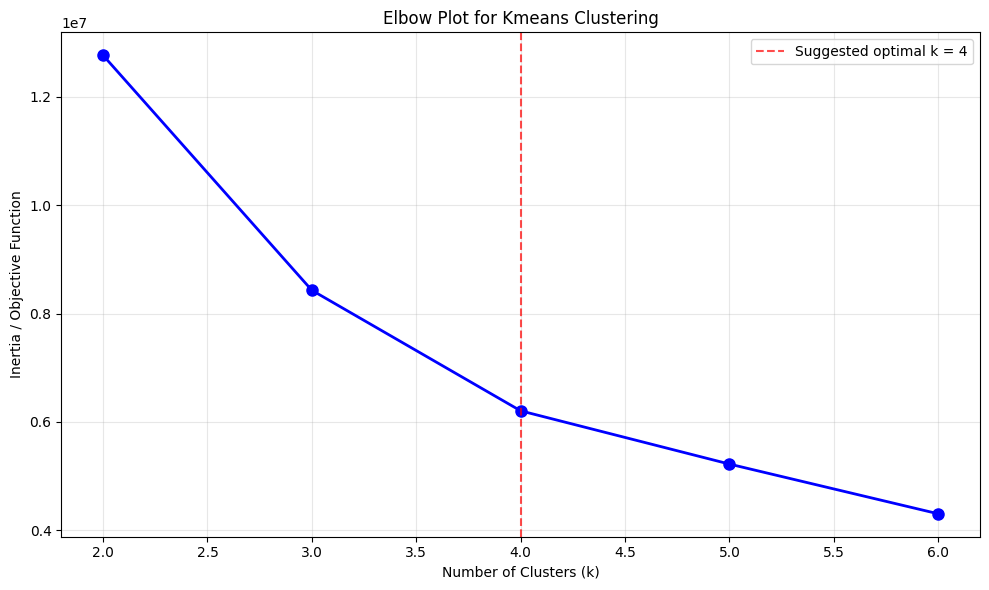

{'k_values': [2, 3, 4, 5, 6],
 'inertias': [12766496.89727619,
  8428790.931686714,
  6203977.6564152185,
  5221082.573852937,
  4303441.419101351],
 'optimal_k': 4}

In [166]:
kmeans_elbow_analysis = elbow_plot(raw_img, 'kmeans', k_min=2, k_max=6)
kmeans_elbow_analysis

Testing kmedoids clustering for k = 2 to 6...


ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

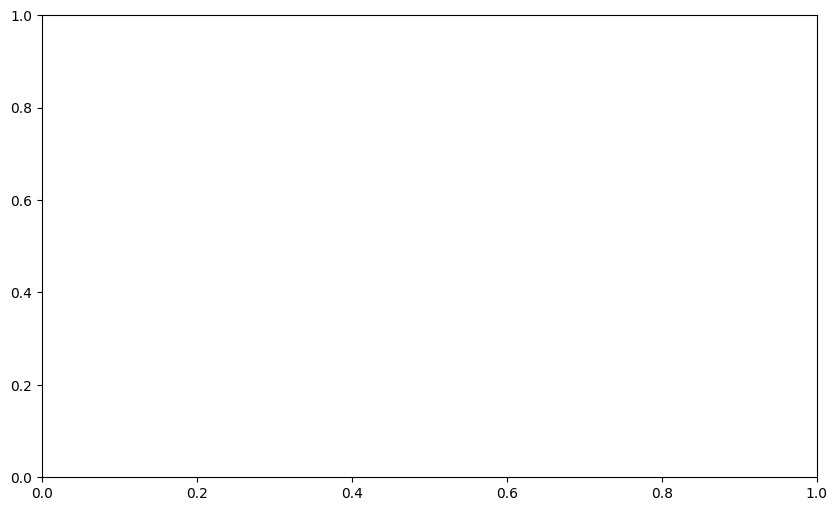

In [167]:
kmedoids_elbow_analysis = elbow_plot(raw_img, 'kmedoids', k_min=2, k_max=6)
kmedoids_elbow_analysis

In [101]:
def silhouette_plot(X, model, k_min=2, k_max=10, figsize=(10, 6)):
    """
    Generate silhouette plot for clustering evaluation
    
    Parameters:
    -----------
    X : numpy.ndarray or list of numpy.ndarray
        Data for clustering. If list, uses first element
    model : str
        Model name ('kmeans', 'kmedoids', 'meanshift', 'fuzzy_cmeans')
    k_min : int, default=2
        Minimum number of clusters to test
    k_max : int, default=10
        Maximum number of clusters to test
    figsize : tuple, default=(10, 6)
        Figure size for the plot
    
    Returns:
    --------
    dict: Dictionary containing:
        - 'k_values': range of k values tested
        - 'silhouette_scores': list of silhouette scores
        - 'optimal_k': suggested optimal k (highest silhouette score)
    """
    from sklearn.metrics import silhouette_score
    
    # Handle list input (take first element)
    data = X
    
    if data.size == 0:
        print("Error: No data provided")
        return None
    
    k_values = range(k_min, k_max + 1)
    silhouette_scores = []
    
    print(f"Testing {model} clustering silhouette scores for k = {k_min} to {k_max}...")
    
    for k in k_values:
        try:
            if model.lower() == 'kmeans':
                results = group_with_kmeans(data, n_clusters=k)
                if results and len(np.unique(results['labels'])) > 1:
                    score = silhouette_score(data, results['labels'])
                    silhouette_scores.append(score)
                else:
                    silhouette_scores.append(-1)  # Invalid clustering
            """
            elif model.lower() == 'kmedoids':
                results = group_samples_with_kmedoids([data], n_clusters=k)
                if results and len(np.unique(results[0]['labels'])) > 1:
                    labels = results[0]['labels']
                    score = silhouette_score(data, labels)
                    silhouette_scores.append(score)
                else:
                    silhouette_scores.append(-1)
            
            elif model.lower() == 'fuzzy_cmeans' or model.lower() == 'fuzzy':
                results = group_samples_with_fuzzy_cmeans([data], n_clusters=k)
                if results and len(np.unique(results[0]['labels'])) > 1:
                    labels = results[0]['labels']
                    score = silhouette_score(data, labels)
                    silhouette_scores.append(score)
                else:
                    silhouette_scores.append(-1)
            
            elif model.lower() == 'meanshift':
                # For Mean Shift, we can test different bandwidth values
                # Use bandwidth as a proxy for k (smaller bandwidth = more clusters)
                base_bandwidth = 0.5 / k  # Inverse relationship
                results = group_samples_with_meanshift([data], bandwidth=base_bandwidth)
                if results and len(np.unique(results[0]['labels'])) > 1:
                    labels = results[0]['labels']
                    actual_k = results[0]['n_clusters']
                    score = silhouette_score(data, labels)
                    silhouette_scores.append(score)
                    print(f"k={k} (bandwidth={base_bandwidth:.4f}) -> {actual_k} clusters, silhouette={score:.3f}")
                else:
                    silhouette_scores.append(-1)
            
            else:
                print(f"Error: Unknown model '{model}'. Available: 'kmeans', 'kmedoids', 'fuzzy_cmeans', 'meanshift'")
                return None
            """    
        except Exception as e:
            print(f"Error at k={k}: {e}")
            silhouette_scores.append(-1)
    
    # Find optimal k (highest silhouette score)
    valid_scores = [s for s in silhouette_scores if s > -1]
    print('Valid scores: ',len(valid_scores))
    if valid_scores:
        optimal_idx = np.argmax(silhouette_scores)
        optimal_k = k_values[optimal_idx]
        max_score = silhouette_scores[optimal_idx]
    else:
        optimal_k = k_values[0]
        max_score = -1
    
    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(k_values, silhouette_scores, 'go-', linewidth=2, markersize=8)
    
    if max_score > -1:
        plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
                    label=f'Optimal k = {optimal_k} (score = {max_score:.3f})')
        plt.axhline(y=max_score, color='red', linestyle=':', alpha=0.5)
    
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Analysis for {model.title()} Clustering')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add score annotations
    for i, (k, score) in enumerate(zip(k_values, silhouette_scores)):
        if score > -1:
            plt.annotate(f'{score:.3f}', (k, score), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=9, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nSilhouette Score Summary for {model.title()}:")
    print("=" * 40)
    for k, score in zip(k_values, silhouette_scores):
        status = "✓" if score > 0.5 else "○" if score > 0.3 else "✗" if score > -1 else "ERROR"
        print(f"k={k:2d}: {score:6.3f} {status}")
    
    return {
        'k_values': list(k_values),
        'silhouette_scores': silhouette_scores,
        'optimal_k': optimal_k,
        'max_score': max_score
    }

Testing kmeans clustering silhouette scores for k = 2 to 6...
Valid scores:  5


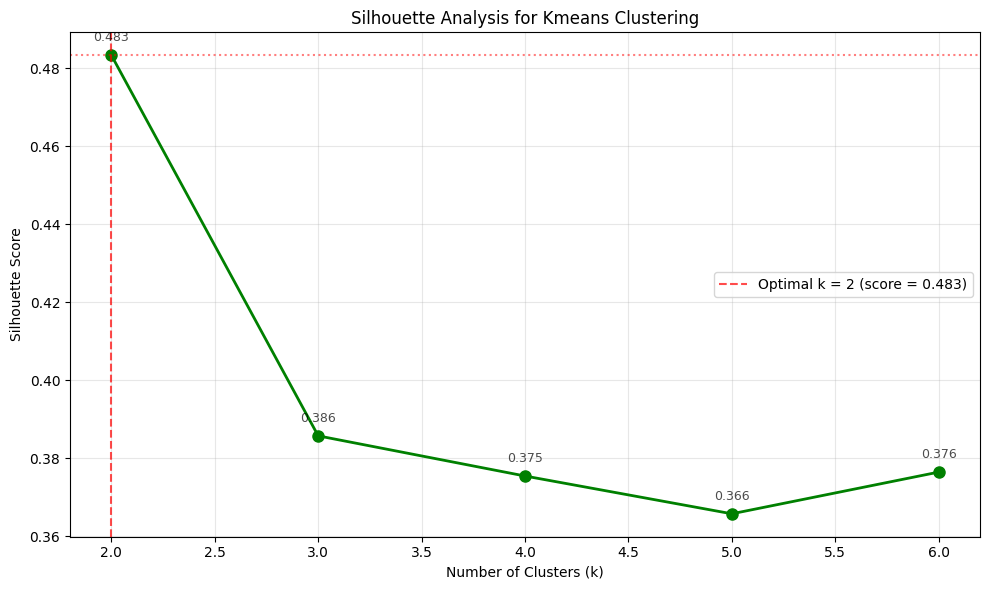


Silhouette Score Summary for Kmeans:
k= 2:  0.483 ○
k= 3:  0.386 ○
k= 4:  0.375 ○
k= 5:  0.366 ○
k= 6:  0.376 ○


{'k_values': [2, 3, 4, 5, 6],
 'silhouette_scores': [0.4833635173697883,
  0.3857718370941293,
  0.3754753238169633,
  0.3657870965595086,
  0.37647936880662836],
 'optimal_k': 2,
 'max_score': 0.4833635173697883}

In [102]:
silhouette_plot_result = silhouette_plot(raw_img, 'kmeans', k_min=2, k_max=6)
silhouette_plot_result

In [105]:
def silhouette_analysis(X, model, k_min=2, k_max=6, figsize=(15, 10)):
    from sklearn.metrics import silhouette_score, silhouette_samples
    import matplotlib.cm as cm

    data = X
    
    k_values = range(k_min, k_max + 1)
    n_plots = len(k_values)
    
    # Calculate subplot layout
    cols = min(3, n_plots)
    rows = (n_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    results = {}
    overall_scores = []
    
    print(f"Generating detailed silhouette analysis for {model} (k = {k_min} to {k_max})...")
    
    for idx, k in enumerate(k_values):
        try:
            # Get clustering results
            if model.lower() == 'kmeans':
                cluster_results = group_with_kmeans(data, n_clusters=k)
            """
            elif model.lower() == 'kmedoids':
                cluster_results = group_samples_with_kmedoids([data], n_clusters=k)
            elif model.lower() == 'fuzzy_cmeans' or model.lower() == 'fuzzy':
                cluster_results = group_samples_with_fuzzy_cmeans([data], n_clusters=k)
            elif model.lower() == 'meanshift':
                print("Note: Mean Shift automatically determines clusters. Using fixed bandwidth approach.")
                base_bandwidth = 0.5 / k
                cluster_results = group_samples_with_meanshift([data], bandwidth=base_bandwidth)
                if cluster_results:
                    actual_k = cluster_results[0]['n_clusters']
                    if actual_k != k:
                        print(f"Mean Shift with bandwidth {base_bandwidth:.4f} found {actual_k} clusters (expected {k})")
            else:
                print(f"Error: Unknown model '{model}'")
                return None
            """
                
            labels = cluster_results['labels']
            
            # Skip if only one cluster
            if len(np.unique(labels)) <= 1:
                print(f"Only one cluster found for k={k}, skipping")
                continue
            
            # Calculate silhouette scores
            sample_silhouette_values = silhouette_samples(data, labels)
            silhouette_avg = silhouette_score(data, labels)
            overall_scores.append(silhouette_avg)
            
            # Create subplot
            ax = axes[idx] if idx < len(axes) else None
            if ax is None:
                continue
                
            y_lower = 10
            colors = cm.nipy_spectral(np.linspace(0, 1, k))
            
            cluster_silhouette_avgs = []
            
            for i in range(k):
                # Get silhouette scores for samples in cluster i
                cluster_silhouette_values = sample_silhouette_values[labels == i]
                
                if len(cluster_silhouette_values) == 0:
                    continue
                    
                cluster_silhouette_avgs.append(np.mean(cluster_silhouette_values))
                cluster_silhouette_values.sort()
                
                size_cluster_i = cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i
                
                color = colors[i]
                ax.fill_betweenx(np.arange(y_lower, y_upper),
                               0, cluster_silhouette_values,
                               facecolor=color, edgecolor=color, alpha=0.7)
                
                # Label the silhouette plots with cluster numbers at the middle
                ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10
            
            ax.set_xlabel('Silhouette Score')
            ax.set_ylabel('Cluster Label')
            ax.set_title(f'{model.title()}: k={k}\nAvg Score: {silhouette_avg:.3f}')
            
            # Add vertical line for average silhouette score
            ax.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.8, linewidth=2)
            
            # Set x-axis limits
            ax.set_xlim([-0.1, 1])
            ax.set_ylim([0, len(data) + (k + 1) * 10])
            
            # Store results
            results[k] = {
                'labels': labels,
                'sample_silhouette_values': sample_silhouette_values,
                'silhouette_avg': silhouette_avg,
                'cluster_silhouette_avgs': cluster_silhouette_avgs,
                'n_clusters': len(np.unique(labels))
            }
            
        except Exception as e:
            print(f"Error processing k={k}: {e}")
            continue
    
    # Hide empty subplots
    for idx in range(len(k_values), len(axes)):
        if idx < len(axes):
            axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nSilhouette Analysis Summary for {model.title()}:")
    print("=" * 50)
    print("k  | Avg Score | Cluster Scores")
    print("-" * 50)
    
    best_k = None
    best_score = -1
    
    for k in k_values:
        if k in results:
            result = results[k]
            avg_score = result['silhouette_avg']
            cluster_scores = result['cluster_silhouette_avgs']
            
            if avg_score > best_score:
                best_score = avg_score
                best_k = k
            
            cluster_scores_str = ', '.join([f'{score:.3f}' for score in cluster_scores])
            status = "✓" if avg_score > 0.5 else "○" if avg_score > 0.3 else "✗"
            print(f"{k:2d} | {avg_score:8.3f} | [{cluster_scores_str}] {status}")
    
    if best_k:
        print(f"\nRecommended k: {best_k} (score: {best_score:.3f})")
    
    return results

Generating detailed silhouette analysis for kmeans (k = 2 to 6)...


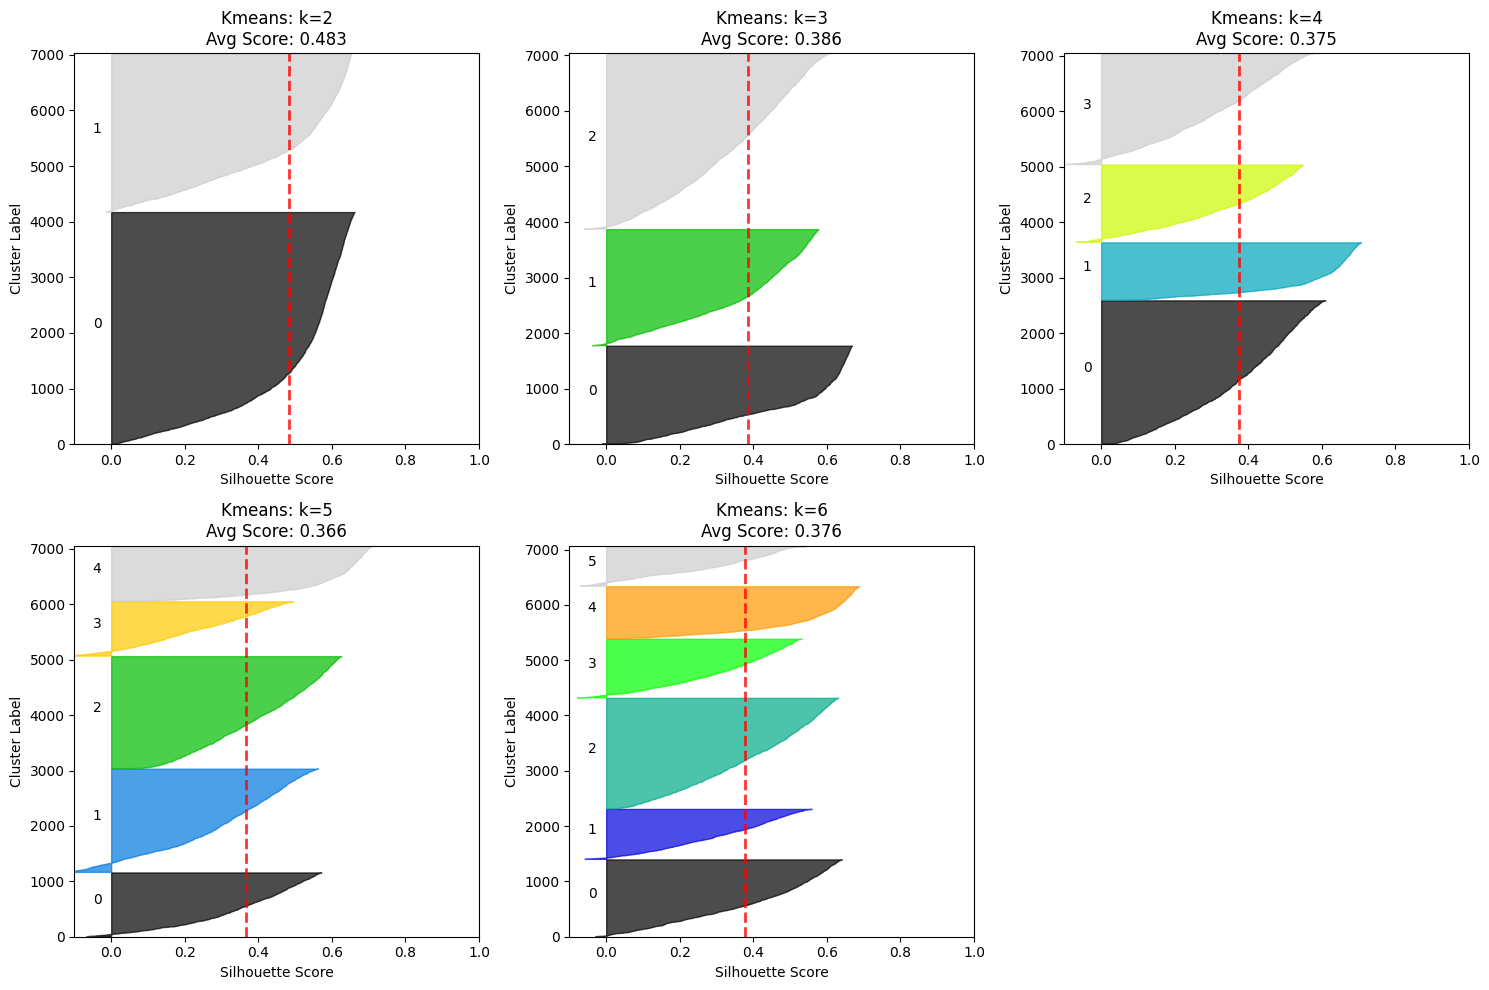


Silhouette Analysis Summary for Kmeans:
k  | Avg Score | Cluster Scores
--------------------------------------------------
 2 |    0.483 | [0.499, 0.461] ○
 3 |    0.386 | [0.482, 0.367, 0.344] ○
 4 |    0.375 | [0.375, 0.564, 0.333, 0.307] ○
 5 |    0.366 | [0.348, 0.291, 0.408, 0.236, 0.571] ○
 6 |    0.376 | [0.394, 0.306, 0.391, 0.313, 0.539, 0.270] ○

Recommended k: 2 (score: 0.483)


In [106]:
silhouette_analysis_results = silhouette_analysis(raw_img, 'kmeans', k_min=2, k_max=6)

In [115]:
def palette_plot(clustering_results, model_name=None, figsize=(12, 8), show_counts=True, sort_by_frequency=True):

    import matplotlib.patches as mpatches

    if model_name == "kmeans":
        palette = clustering_results['centroids']

    # Display the palette
    plt.figure(figsize=(6, 2))
    for i, color in enumerate(palette):
        plt.gca().add_patch(    
            mpatches.Rectangle((i, 0), 1, 1, color=color / 255)
        )
    plt.xlim(0, len(palette))
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Color Palette from KMeans Centroids')
    plt.show()


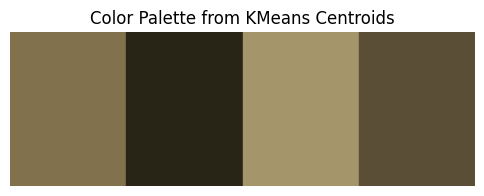

In [116]:
kmeans_grouping = group_with_kmeans(raw_img, n_clusters=4)
palette_plot(kmeans_grouping, model_name="kmeans")



In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

scaler = StandardScaler()
img_std = scaler.fit_transform(raw_img)

pca = PCA(n_components=2)
img_reduced = pca.fit_transform(img_std)

sum(pca.explained_variance_ratio_)

tsne = TSNE(random_state=0, verbose=1)
img_tsne = pd.DataFrame(tsne.fit_transform(img_reduced))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.004s...
[t-SNE] Computed neighbors for 7000 samples in 0.061s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.067237
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.152527
[t-SNE] KL divergence after 1000 iterations: 0.678958


In [ ]:
def plot_clusters_2d(raw_data, clustering_results, figsize=(15, 6), random_state=42):
    """
    Reduce clustering results to 2D using both PCA and t-SNE and plot with cluster colors
    
    Parameters:
    -----------
    raw_data : numpy.ndarray
        Original image data (flattened RGB values)
    clustering_results : dict
        Results from K-means clustering containing 'labels' and 'centroids'
    figsize : tuple, default=(15, 6)
        Figure size for the plot
    random_state : int, default=42
        Random state for reproducibility
    
    Returns:
    --------
    dict: Dictionary containing reduced data and plot information
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import numpy as np
    
    labels = clustering_results['labels']
    centroids = clustering_results['centroids']
    n_clusters = clustering_results['n_clusters']
    
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(raw_data)
    
    # PCA reduction
    pca = PCA(n_components=2, random_state=random_state)
    data_pca = pca.fit_transform(data_scaled)
    
    # t-SNE reduction (use PCA-reduced data if original is high-dimensional)
    if data_scaled.shape[1] > 50:
        pca_pre = PCA(n_components=50, random_state=random_state)
        data_for_tsne = pca_pre.fit_transform(data_scaled)
    else:
        data_for_tsne = data_scaled
        
    tsne = TSNE(n_components=2, random_state=random_state, verbose=1)
    data_tsne = tsne.fit_transform(data_for_tsne)
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Colors for clusters (use centroids normalized to [0,1])
    cluster_colors = centroids / 255.0
    
    # PCA Plot
    ax_pca = axes[0]
    for i in range(n_clusters):
        cluster_mask = labels == i
        ax_pca.scatter(data_pca[cluster_mask, 0], data_pca[cluster_mask, 1], 
                      c=[cluster_colors[i]], alpha=0.6, s=20, 
                      label=f'Cluster {i} (n={np.sum(cluster_mask)})')
    
    ax_pca.set_xlabel('First Principal Component')
    ax_pca.set_ylabel('Second Principal Component')
    ax_pca.set_title(f'PCA Visualization of K-Means Clusters\n'
                    f'Explained Variance: {sum(pca.explained_variance_ratio_):.3f}')
    ax_pca.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_pca.grid(True, alpha=0.3)
    
    # t-SNE Plot
    ax_tsne = axes[1]
    for i in range(n_clusters):
        cluster_mask = labels == i
        ax_tsne.scatter(data_tsne[cluster_mask, 0], data_tsne[cluster_mask, 1], 
                       c=[cluster_colors[i]], alpha=0.6, s=20,
                       label=f'Cluster {i} (n={np.sum(cluster_mask)})')
    
    ax_tsne.set_xlabel('t-SNE 1')
    ax_tsne.set_ylabel('t-SNE 2')
    ax_tsne.set_title('t-SNE Visualization of K-Means Clusters')
    ax_tsne.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_tsne.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Clustering Visualization Summary:")
    print(f"- Original data shape: {raw_data.shape}")
    print(f"- Number of clusters: {n_clusters}")
    print(f"- PCA explained variance: {sum(pca.explained_variance_ratio_):.3f}")
    print(f"- PCA components variance: {pca.explained_variance_ratio_}")
    
    for i in range(n_clusters):
        count = np.sum(labels == i)
        percentage = (count / len(labels)) * 100
        rgb_str = f"RGB({int(centroids[i][0])}, {int(centroids[i][1])}, {int(centroids[i][2])})"
        print(f"- Cluster {i}: {count} pixels ({percentage:.1f}%) - {rgb_str}")
    
    return {
        'pca': {
            'data_2d': data_pca,
            'explained_variance': pca.explained_variance_ratio_,
            'total_variance': sum(pca.explained_variance_ratio_)
        },
        'tsne': {
            'data_2d': data_tsne
        }
    }

In [ ]:
# Apply 2D visualization to K-means results
visualization_results = plot_clusters_2d(raw_img, kmeans_grouping)